### Lab: KFold, Regularization, & Pipelines

Welcome!  This lab is going to introduce us to some very important aspects of data processing and model building.  

Specifically, it's going to go over the following:

 - **KFold Cross Validation:** This is a more thorough way of choosing your validation set to give you a better idea of how your model might perform under various circumstances within your training data.
 - **Regularization:** This is an evergreen technique for dealing with models that are overfit (ie, higher scores on training vs. test data).  Regularized linear models are often much better prepared to handle messy data & outliers when using this technique.
 - **Pipelines:** (Time permitting!) This is an underappreciated aspect of the Scikit-Learn api that allows you to chain together multiple data processing steps, making it much easier to test different models and work seamlessly between your training & test sets.

**Note:** This lab builds off of the one performed in the last class.  As such, it might be easier just to keep working in your previous lab to answer these questions.  It assumes you already have your data processed from the iowa housing lab.  

The questions are listed here just to make the separation of concerns easier.

### Question 1: How Does Your Validation Score Differ Using KFold Cross Validation?

Take a look at the validation score you got from your previous exercise.  

This time, run your model through KFold cross validation using `cross_val_score`.  Is your total validation score appreciably different?  What were your highest and lowest values?

What if you changed your number of folds?  Try using 5, 10, & 25 folds.

In [12]:
# these are the steps from the previous lab
import pandas as pd
import numpy as np
train = pd.read_csv('../data/iowa_housing/train.csv')
test  = pd.read_csv('../data/iowa_housing/test.csv')

# your answer here
y = train['SalePrice']
train.drop('SalePrice', axis=1, inplace=True)
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

train_empty = train.loc[:, train.isnull().sum() > 0]
# grab the columns
cols = train_empty.columns.tolist()
# fill with the appropriate value  -- NA, Other, could also work
train[['GarageType', 'GarageFinish']] = train[['GarageType', 'GarageFinish']].fillna('None')
test[['GarageType', 'GarageFinish']]  = test[['GarageType', 'GarageFinish']].fillna('None')

# we'll use this for GarageYrBlt since it's a numeric column
train['GarageYrBlt'].fillna(0, inplace=True)
test['GarageYrBlt'].fillna(0, inplace=True)

# finding the values to use in the training set
ms_mode   = train['MSZoning'].mode()[0]
gcarsmean = train['GarageCars'].mean()

# and applying them to the test set
test['MSZoning'].fillna(ms_mode, inplace=True)
test['GarageCars'].fillna(gcarsmean, inplace=True)

# your code here
# we'll assume the GarageFinish is ordinal.  Ie, FinishedGarage > Unfinished Garage
garage_mapping = {
    'None': 0, # no garage
    'Unf' : 1, # unfinished garage
    'RFn' : 2, # partially finished garage
    'Fin' : 3  # finished garage
}

train['GarageFinish'] = train['GarageFinish'].map(garage_mapping)
test['GarageFinish']  = test['GarageFinish'].map(garage_mapping)

# MSSubClass is really a category, moreso than a true number
# so we'll add it to the list of items to be encoded
train['MSSubClass'] = train['MSSubClass'].astype(str)
test['MSSubClass']  = test['MSSubClass'].astype(str)

# concatenate and encode
master = pd.concat([train, test])
master = pd.get_dummies(master)

# drop MSSubClass150
master.drop('MSSubClass_150', axis=1, inplace=True)

# and split back apart
train  = master.iloc[:1460].copy()
test   = master.iloc[1460:].copy()

# save these values, to use on both your training and test set
train_means = train.mean()
train_stds  = train.std()

# standardize the training set
train -= train_means
train /= train_stds

# and do the same for the test set
test -= train_means
test /= train_stds

In [24]:
# this is the part where we use KFold to find your validation score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
lreg = LinearRegression()
# we'll use a loop to go through these
cv_scores = []
num_folds = [5, 10, 25]

for fold in num_folds:
    scores = cross_val_score(estimator=lreg, X=train, y=np.log(y), cv=fold)
    cv_scores.append(scores)

In [25]:
# first we'll look at the different scores
cv_dict = {}
for idx, fold in enumerate(num_folds):
    cv_dict[f'folds: {fold}'] = np.mean(cv_scores[idx])

In [26]:
# scores are roughly the same, but lower than just the general validation score
# we had before
cv_dict

{'folds: 5': 0.8645586208190448,
 'folds: 10': 0.8627736666706329,
 'folds: 25': 0.8613078461662019}

In [29]:
cv_scores[2]

array([0.89302007, 0.82477951, 0.87092049, 0.92495534, 0.91648344,
       0.93185865, 0.88948408, 0.84754801, 0.80089708, 0.83188453,
       0.88281676, 0.89318777, 0.82773939, 0.8835977 , 0.84607624,
       0.90444633, 0.82149406, 0.91933525, 0.87860388, 0.88391928,
       0.88033665, 0.91063222, 0.49020936, 0.91349123, 0.86497884])

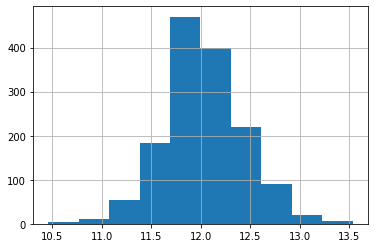

In [18]:
np.log(y).hist()

In [22]:
(np.log(68000) - np.log(70000))**2

0.0008402772939781673

In [23]:
(np.log(680000) - np.log(700000))**2

0.0008402772939781673

In [19]:
np.log(y)

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
5       11.870600
6       12.634603
7       12.206073
8       11.774520
9       11.678440
10      11.771436
11      12.751300
12      11.877569
13      12.540758
14      11.964001
15      11.790557
16      11.911702
17      11.407565
18      11.976659
19      11.842229
20      12.692503
21      11.845103
22      12.345835
23      11.774520
24      11.944708
25      12.454104
26      11.811547
27      12.631340
28      12.242887
29      11.134589
          ...    
1430    12.165980
1431    11.875831
1432    11.074421
1433    12.136187
1434    11.982929
1435    12.066811
1436    11.699405
1437    12.885671
1438    11.916389
1439    12.190959
1440    12.160029
1441    11.913713
1442    12.644328
1443    11.703546
1444    12.098487
1445    11.767568
1446    11.969717
1447    12.388394
1448    11.626254
1449    11.429544
1450    11.820410
1451    12.567551
1452    11.884489
1453    11.344507
1454    12

In [16]:
cv_scores[2]

array([0.89179913, 0.82489895, 0.87746131, 0.86067351, 0.89600987,
       0.90576855, 0.89201931, 0.81643292, 0.74565768, 0.79187226,
       0.87308117, 0.80829943, 0.8144443 , 0.82323958, 0.90730437,
       0.78436402, 0.8719923 , 0.84965521, 0.77001554, 0.81476842,
       0.75186355, 0.86480539, 0.11688019, 0.86987915, 0.87815075])

### Question 2: Updating Your Model With Ridge & Lasso Regression

Instead of using Linear Regression, import `Ridge` or `Lasso`, and use cross validation to find the ideal value of alpha.  

Some basic tips:

For values of alpha try this:  `alphas = np.logspace(-4, 4, 9)`
Then write a `for-loop` that generically goes like this:

`for value in alphas:
    1). set value of alpha to current value using set_params() method
    2). pass in instance of Ridge or Lasso into cross_val_score
    3). using a tuple, append the average of all results from step 2 into a list, along with the value of alpha`
    
When you're finished, you should have a list that has 9 tuples inside it, each one with the average cross validation score as well as the value of alpha associated with it.

In [462]:
# your answer here
from sklearn.linear_model import Ridge, Lasso
ridge = Ridge()
# the max_iter argument will silence a warning message
lasso = Lasso()
alphas = np.logspace(-3, 3, 7)
ridge_scores = []
lasso_scores = []

for value in alphas:
    ridge.set_params(alpha=value)
    lasso.set_params(alpha=value)
    lasso_score = cross_val_score(estimator=lasso, X=train, y=y, cv=10)
    ridge_score = cross_val_score(estimator=ridge, X=train, y=y, cv=10)
    ridge_scores.append((np.mean(ridge_score), value))
    lasso_scores.append((np.mean(lasso_score), value))

C:\Users\Jonat\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 699028884335.3823, tolerance: 852398977.1246126
  positive)
C:\Users\Jonat\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 686696896294.1489, tolerance: 827439703.8697118
  positive)
C:\Users\Jonat\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 698419105432.2222, tolerance: 829042909.2707292
  positive)
C:\Users\Jonat\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

C:\Users\Jonat\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 527459574647.6899, tolerance: 829042909.2707292
  positive)
C:\Users\Jonat\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 421616030033.7689, tolerance: 820538852.0864891
  positive)
C:\Users\Jonat\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105723553214.35022, tolerance: 785203388.8728524
  positive)
C:\Users\Jonat\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

In [461]:
# the value of alpha that gives the best score is 100
max(ridge_scores)

(0.8652092706925322, 100.0)

**Bonus:** In Scikit-Learn cross validation is sometimes built into algorithms automatically.  Luckily this is the case with `Ridge` and `Lasso`.  If you're inclined to take a look at the `RidgeCV` and `LassoCV` methods, you can basically combine what we just did into one step.

**RidgeCV:** https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html
**LassoCV:** https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html

### Step 3: Building A Pipeline

Let's try building some pipelines to test out different versions of our models more easily.  

For this one, we are going to start fresh a little bit to get the hang of using our pipelines, and to go through the entire process.

So......

**a)** Reload the training and test sets

 - create a new variable for `y`, and set it equal to the log of `SalePrice`
 - create a variable for the `id` column in the test set -- this will be reused later

In [423]:
train = pd.read_csv('../data/iowa_housing/train.csv')
test  = pd.read_csv('../data/iowa_housing/test.csv')

In [424]:
y = np.log(train['SalePrice'])
train.drop('SalePrice', axis=1, inplace=True)
test_id = test['Id']
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

**b)** Fill in the missing data on training & test

**Note:** If you feel like you have a good handle on this, you can just copy and paste from your previous solutions or the lab manual.  

If you have the time and think you need extra practice, feel free to try and re-create the results on your own.....just be mindful of time.

In [425]:
train_empty = train.loc[:, train.isnull().sum() > 0]
# grab the columns
cols = train_empty.columns.tolist()
# fill with the appropriate value  -- NA, Other, could also work
train[['GarageType', 'GarageFinish']] = train[['GarageType', 'GarageFinish']].fillna('None')
test[['GarageType', 'GarageFinish']]  = test[['GarageType', 'GarageFinish']].fillna('None')

# we'll use this for GarageYrBlt since it's a numeric column
train['GarageYrBlt'].fillna(0, inplace=True)
test['GarageYrBlt'].fillna(0, inplace=True)

# finding the values to use in the training set
ms_mode   = train['MSZoning'].mode()[0]
gcarsmean = train['GarageCars'].mean()

# and applying them to the test set
test['MSZoning'].fillna(ms_mode, inplace=True)
test['GarageCars'].fillna(gcarsmean, inplace=True)

**c)** Reclassify the `MSSubClass` column as a string

In [426]:
train['MSSubClass'] = train['MSSubClass'].astype(str)
test['MSSubClass']  = test['MSSubClass'].astype(str)

**d)** Create Your Pipeline!


a). Initialize instances for each of the following items:

 - An ordinal encoder for the `GarageFinish` column (be careful about the mapping dictionary here)
 - A categorical encoder for your nominal columns
 - The standard scaler
 - Lasso or Ridge regression, with the cross validated value of alpha from the previous exercise

In [428]:
# your answer here
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler

# mapping for the ordinal column
mapping = {
    'col': 'GarageFinish',
    'mapping': garage_mapping
}

# initialize everything
ore   = OrdinalEncoder(cols=['GarageFinish'], mapping=[mapping])
ohe   = OneHotEncoder()
sc    = StandardScaler()
ridge = Ridge(alpha=100)

# make the pipeline
pipe = make_pipeline(ore, ohe, sc, ridge)

**e)** Fit the pipeline on your training set, and predict the values on your test set

 - to get the "real" values of your prediction you would use the function `np.exp()`
 
ie, if `pipe.predict(test)` gives you the predicted log values of your test set, then `np.exp(pipe.predict(test))` would give you the actual expected housing prices.

In [429]:
# fit on the training set
pipe.fit(train, y)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['GarageFinish'], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[{'col': 'GarageFinish',
                                          'mapping': {'Fin': 3, 'None': 0,
                                                      'RFn': 2, 'Unf': 1}}],
                                return_df=True, verbose=0)),
                ('onehotencoder',
                 OneHotEncoder(cols=['MSSubClass', 'MSZoning', 'Neighborhood',
                                     'GarageType'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=False, verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('r

In [430]:
# and predict on the test set
pipe.predict(test)

array([11.67852521, 11.9448299 , 12.05936728, ..., 11.92412032,
       11.66149733, 12.3309958 ])

In [432]:
# and create a dataframe from our test predictions
df              = pd.DataFrame()
df['Id']        = test_id
df['SalePrice'] = np.exp(pipe.predict(test))

In [434]:
# and output to csv
df.to_csv('submissions.csv', index=False)